# Introduction

Pregnancy is a critical period in a woman's life, and monitoring maternal health is of paramount importance to ensure the well-being of both the mother and the unborn child. This notebook focuses on leveraging machine learning techniques to predict the risk level of pregnant women based on key health attributes.

Four different classifiers will be explored for this task:

* Logistic Regression
* K-Nearest Neighbors
* Random Forest
* Gradient Boosting Classifier

By employing these diverse algorithms, this notebook aims to provide a comprehensive analysis of their effectiveness in predicting pregnancy risk levels based on the given health attributes. The insights gained from this analysis can contribute to improved maternal health monitoring and personalized healthcare interventions during pregnancy.

# Importing Packages and Dataset

In [1]:
import warnings
warnings.simplefilter(action ="ignore")

from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Import the necessary packages
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support

# Data directory
import os
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/maternal-health-risk-data/Maternal Health Risk Data Set.csv


In [2]:
# Load Dataset
df = pd.read_csv("../input/maternal-health-risk-data/Maternal Health Risk Data Set.csv")
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


# Data Attributes

The data used for this analysis has been collected from various healthcare sources, including hospitals, community clinics, and maternal health care facilities, through an Internet of Things (IoT) based risk monitoring system (Ahmed and Kashem, 2020; Ahmed et al., 2020). The dataset comprises several essential health attributes that play a crucial role in assessing the risk levels during pregnancy. These attributes include:

1. **Age**: Represents the age of a woman when she is pregnant, measured in years.
2. **SystolicBP**: Denotes the upper value of blood pressure in millimeters of mercury (mmHg), a significant attribute during pregnancy.
3. **DiastolicBP**: Represents the lower value of blood pressure in millimeters of mercury (mmHg), another crucial attribute in maternal health monitoring.
4. **BS**: Indicates blood glucose levels measured in terms of molar concentration, specifically in millimoles per liter (mmol/L).
5. **BodyTemp**: Denotes the body temperature of the pregnant woman in Fahrenheit (°F), providing additional insights into the physiological aspects relevant to maternal health.
6. **HeartRate**: Represents the normal resting heart rate in beats per minute (bpm), a vital parameter for assessing cardiovascular health during pregnancy.
7. **RiskLevel** (Target Variable): Predicted Risk Intensity Level during pregnancy, taking into account the aforementioned health attributes. This variable serves as the target for our machine learning models.

In [3]:
# DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [4]:
print(f"The dataset size: {df.shape}")

The dataset size: (1014, 7)


# Target Variable: Risk Level

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


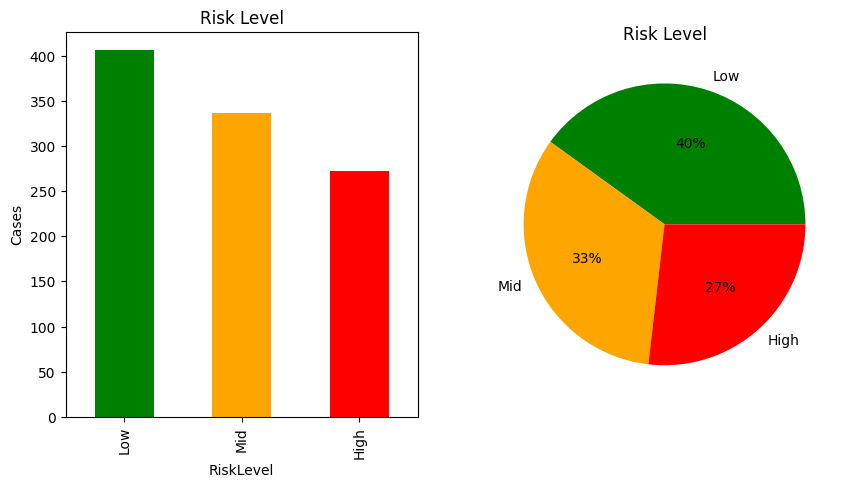

In [5]:
# Plot bar and pie charts for the target variable
total = df["RiskLevel"].count()
low = total - (336 + 272)
mid = total - (406 + 272)
high = total - (406 + 336)
print(df["RiskLevel"].value_counts())

labels = ["Low", "Mid", "High"]
risk_color = ["green", "orange", "red"]

plt.subplot(121)
vis_maternal_health = df.RiskLevel.value_counts().plot(
    figsize=(10, 5),
    kind="bar",
    color=risk_color,
)
plt.title("Risk Level")
plt.ylabel("Cases")
plt.xticks(range(len(labels)), labels)

plt.subplot(122)
plt.title("Risk Level")
vis_maternal_health = plt.pie(
    [low, mid, high],
    labels=labels,
    colors=risk_color,
    autopct="%1.0f%%",
)

plt.show()

The dataset reveals a notable distribution across risk levels. The majority of cases fall into the "Low Risk" category (406 cases), indicating normal health attributes and a lower likelihood of complications during pregnancy. A substantial number of cases are classified as "Mid Risk" (336 cases), suggesting a moderate risk level that requires additional monitoring. Meanwhile, there are 272 cases categorized as "High Risk," signaling a higher risk level that demands close monitoring and potential intervention.

# Feature Variables: Age, SystolicBP, DiastolicBP, BS, BodyTemp and HeartRate

In [6]:
# Convert body temperature from Fahrenheit to Celsius for regional preference
df["BodyTemp"] = (df["BodyTemp"] - 32) * 5/9

In [7]:
# Analyse statically insight of data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.000000,19.000000,26.000000,39.000000,70.000000
SystolicBP,1014.0,113.198225,18.403913,70.000000,100.000000,120.000000,120.000000,160.000000
DiastolicBP,1014.0,76.460552,13.885796,49.000000,65.000000,80.000000,90.000000,100.000000
BS,1014.0,8.725986,3.293532,6.000000,6.900000,7.500000,8.000000,19.000000
BodyTemp,1014.0,37.036160,0.761880,36.666667,36.666667,36.666667,36.666667,39.444444
HeartRate,1014.0,74.301775,8.088702,7.000000,70.000000,76.000000,80.000000,90.000000


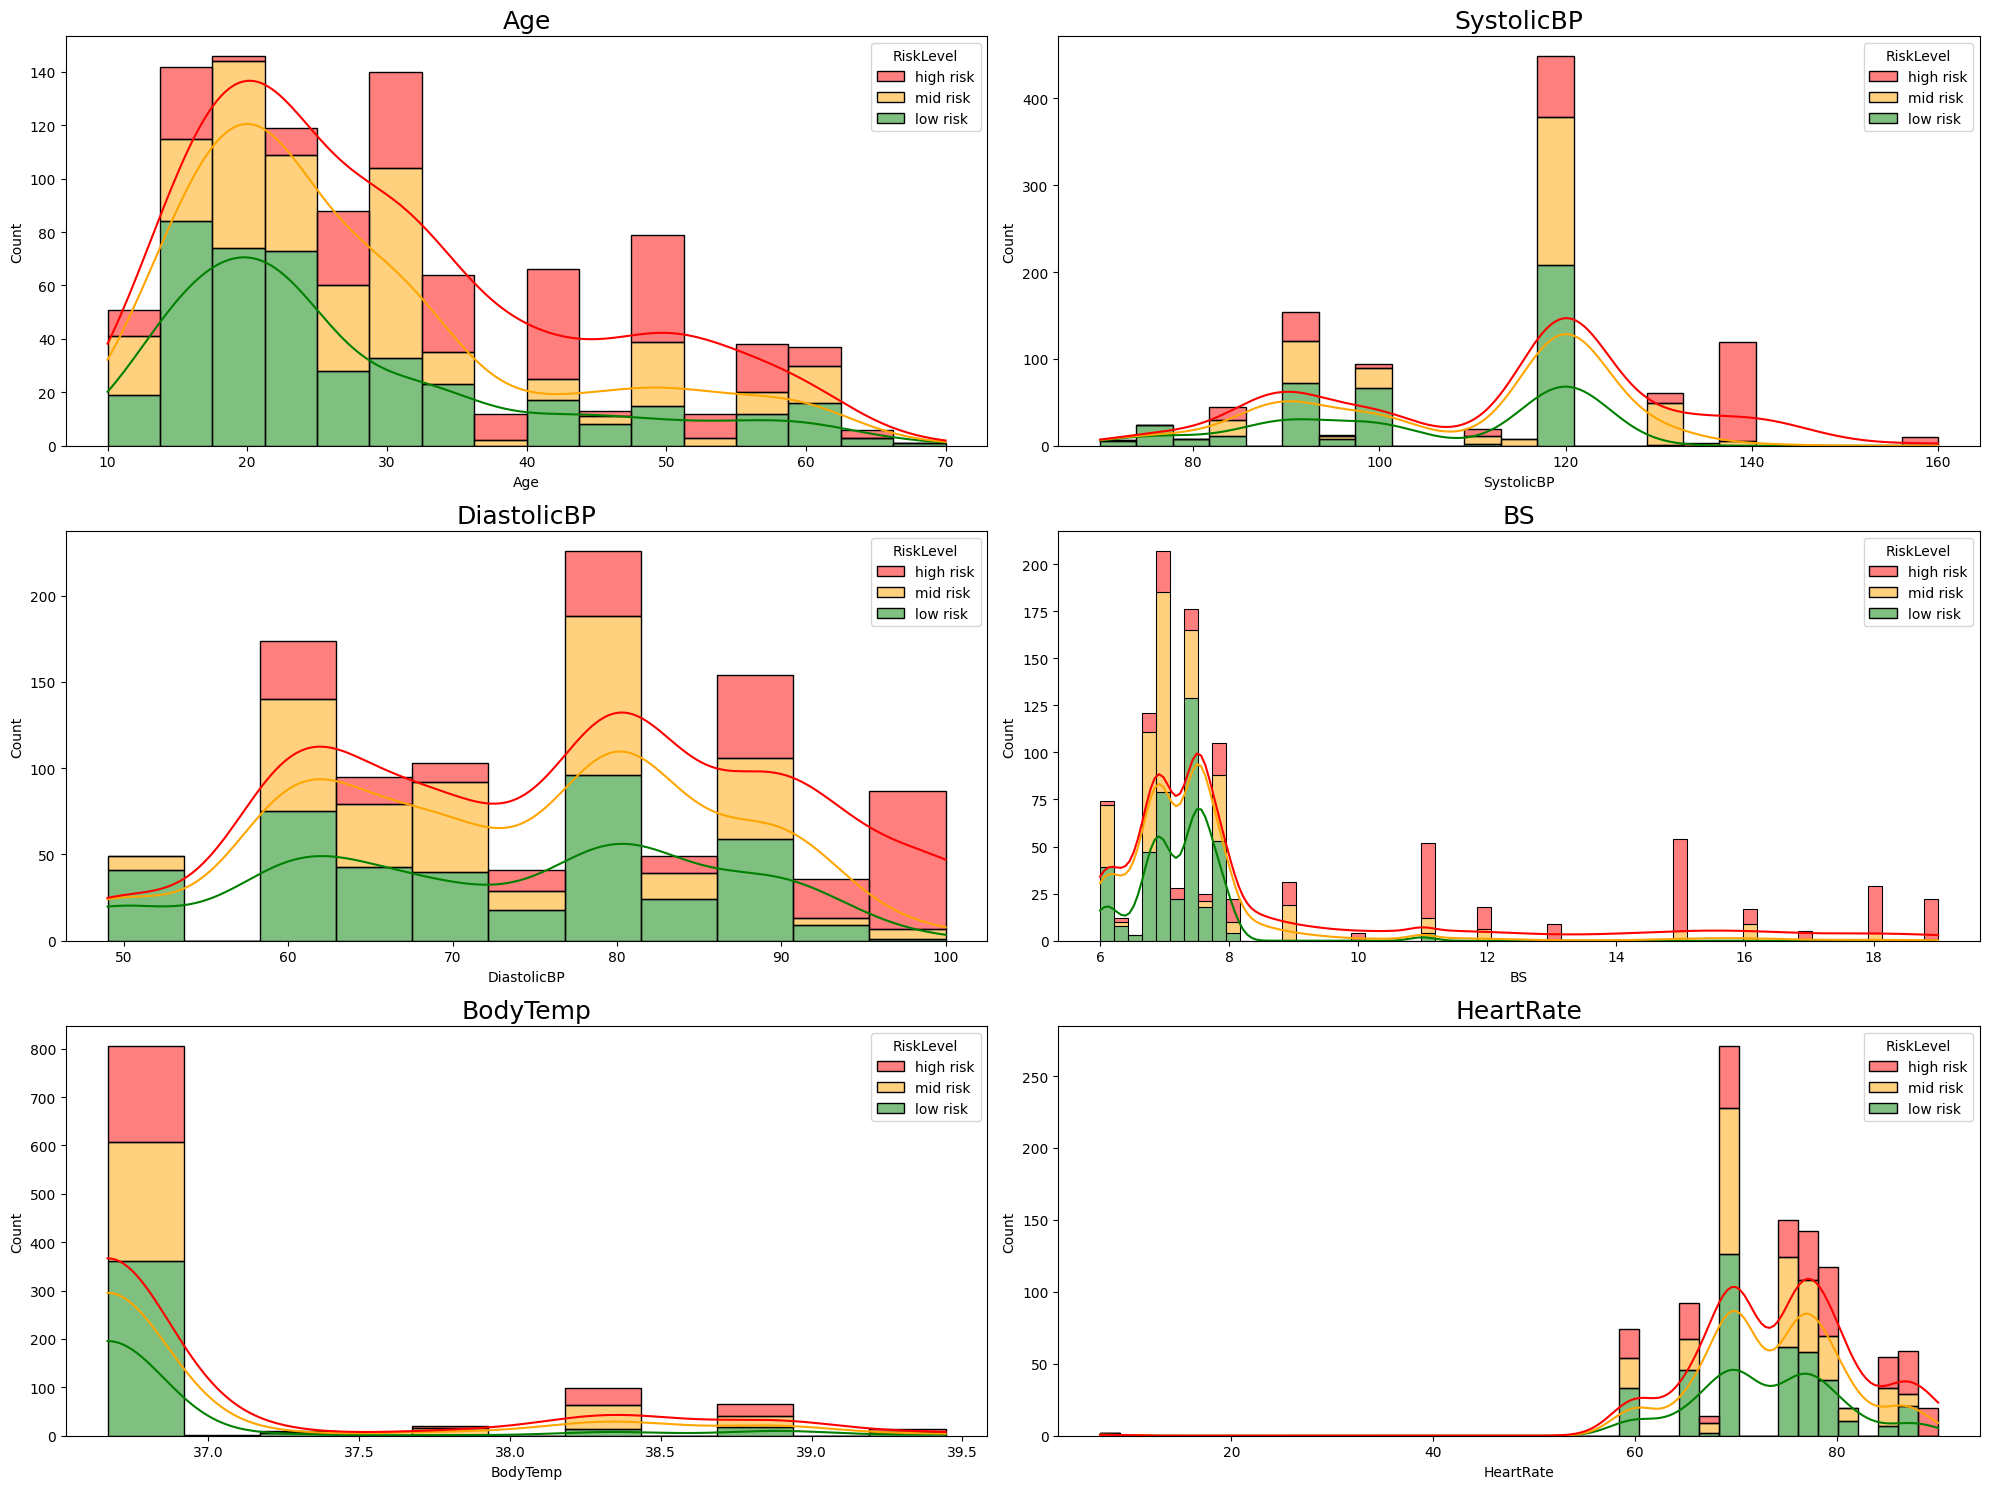

In [8]:
# Plot stacked histograms for the feature variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
risk_level_order = ["high risk", "mid risk", "low risk"]

for ax, column in zip(axes.flatten(), df.columns):
    sns.histplot(data=df, 
                 x=column, 
                 kde=True, 
                 hue="RiskLevel", 
                 hue_order=risk_level_order, 
                 multiple="stack",
                 palette={"low risk": "green", "mid risk": "orange", "high risk": "red"},
                 element="bars", ax=ax)
    ax.set_title(f"{column}", fontsize=18)

plt.tight_layout()
plt.show()

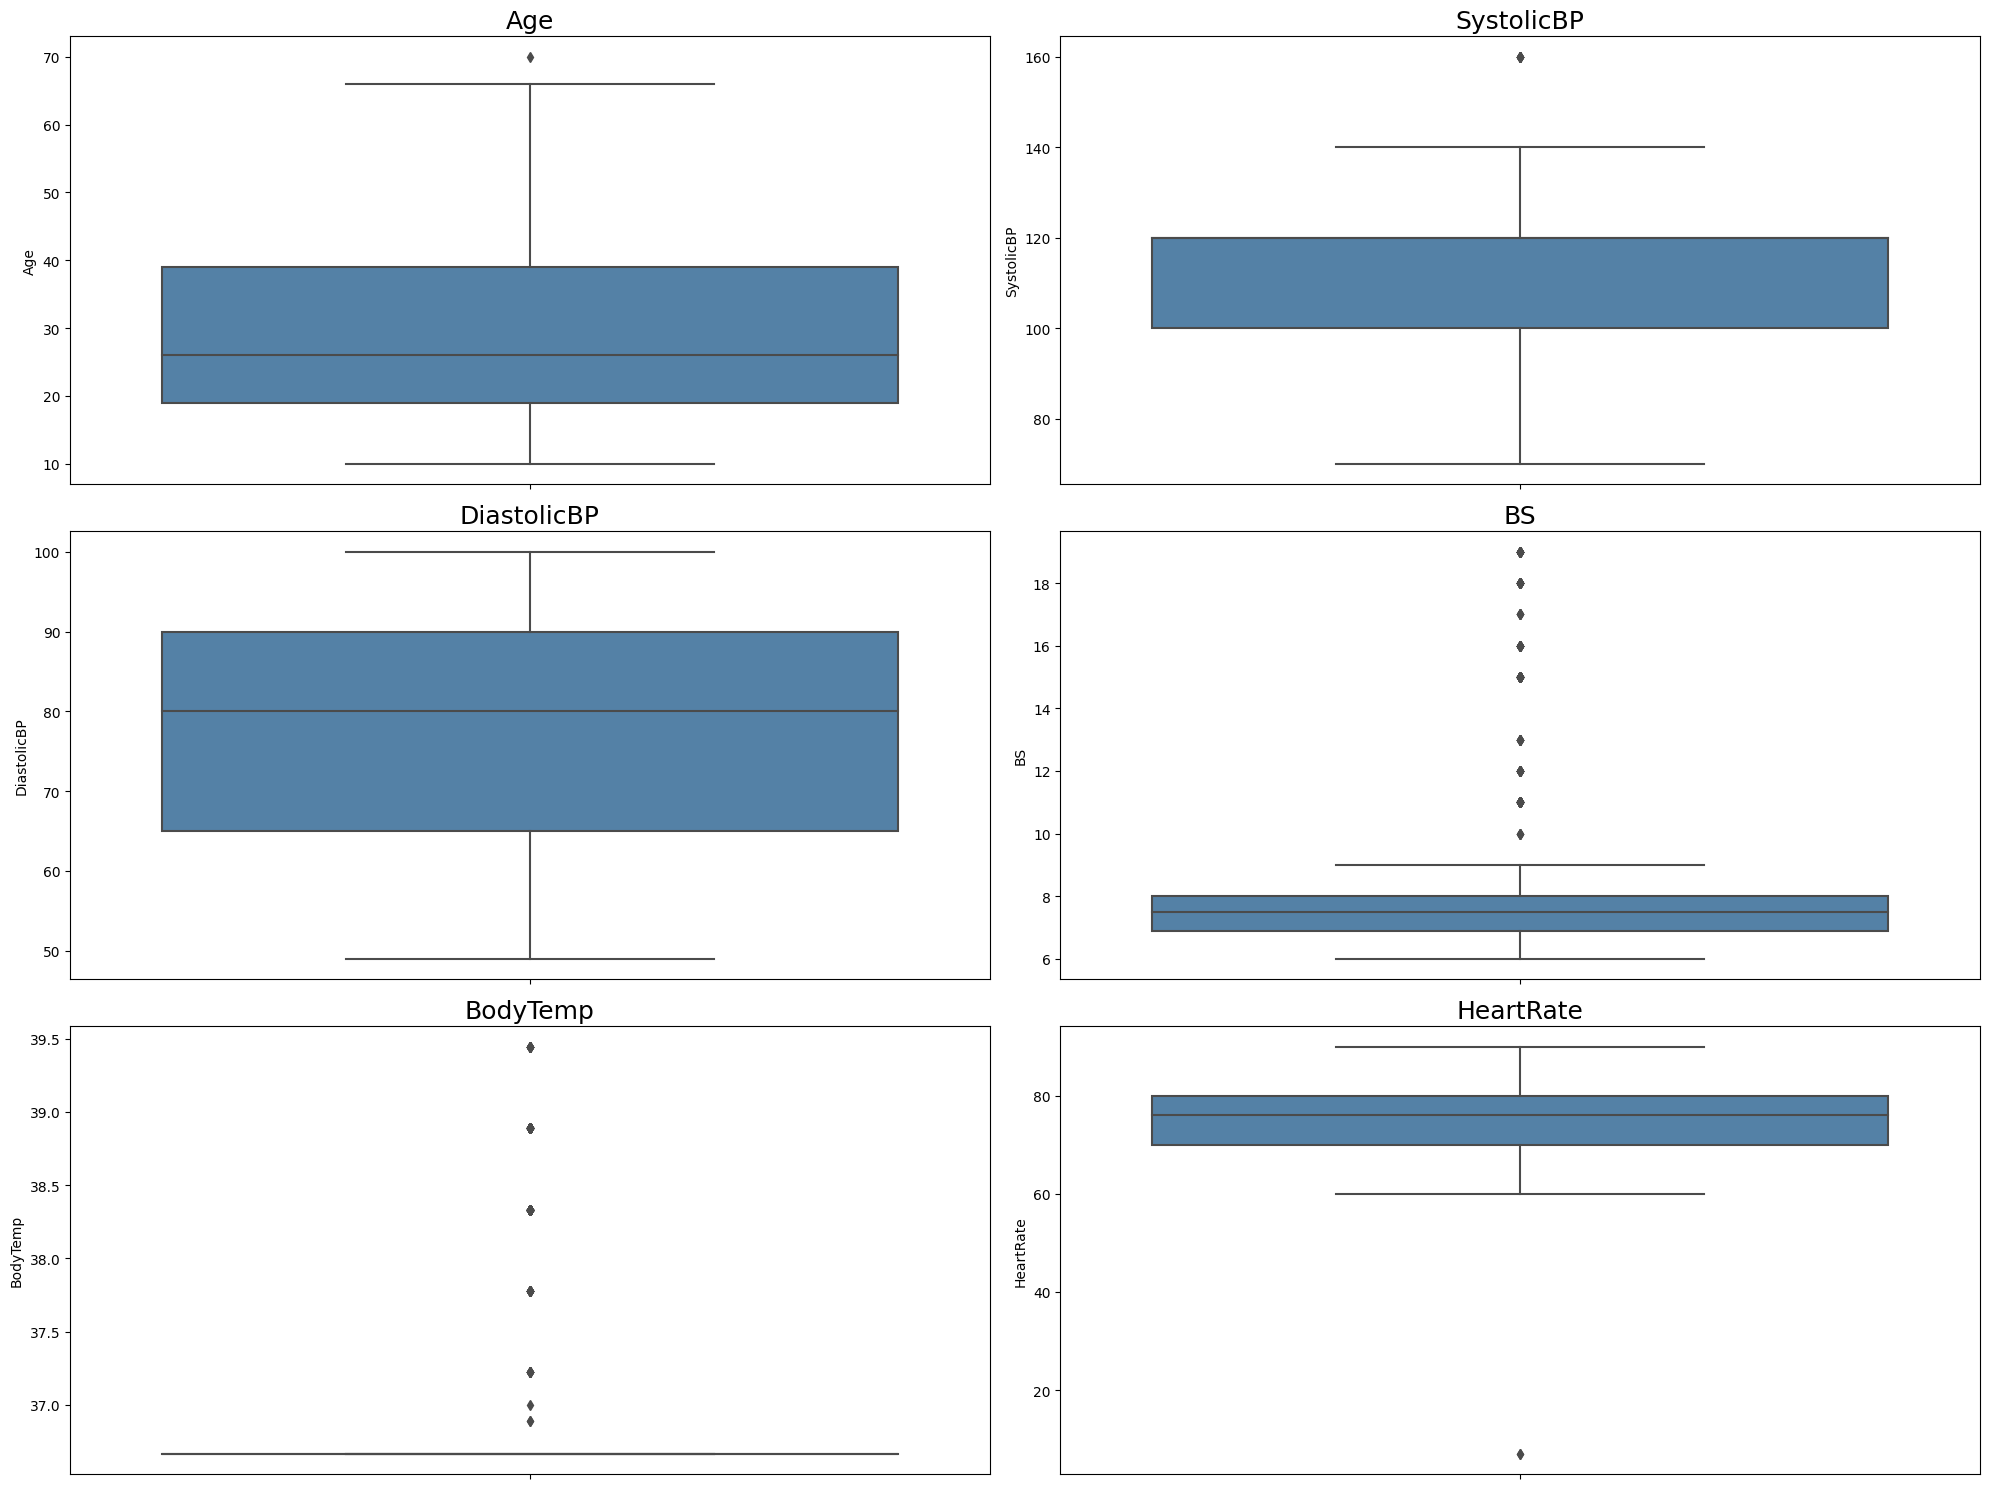

In [9]:
# Plot boxplots for the feature variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

for ax, column in zip(axes.flatten(), df.columns):
    sns.boxplot(y=df[column], 
                color="#4682B4", 
                ax=ax)
    ax.set_title(f"{column}", fontsize=18)

plt.tight_layout()
plt.show()

A pervasive characteristic among the feature variables is their skewed distributions, signaling a departure from the typical bell-shaped curve associated with a normal distribution. Upon closer inspection, the dataset unveils the existence of outliers across multiple features, aberrations that lie notably distant from the majority of data points. One noteworthy anomaly emerges in the 'HeartRate' variable, where a substantial outlier is identified. This outlier implies an anomalous data point, deviating significantly from the general trend. The presence of such an outlier raises the possibility of data input error.

# Correlation Analysis of Variables

In [10]:
# Map RiskLevel to integer values
risk_mapping = {"low risk": 0, "mid risk": 1, "high risk": 2}
df["RiskLevel"] = df["RiskLevel"].map(risk_mapping)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


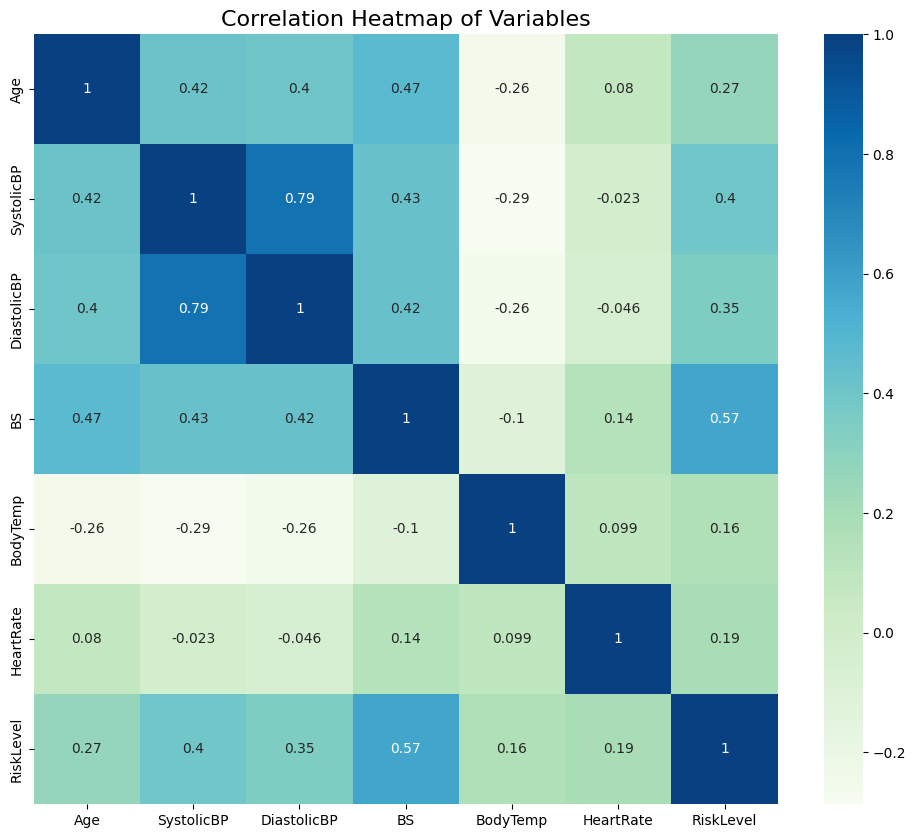

In [11]:
# Create a correlation heatmap
plt.figure(figsize=(12,10))  
sns.heatmap(df.corr(), annot=True, cmap = "GnBu")
plt.title("Correlation Heatmap of Variables", fontsize=16)
plt.show()

SystolicBP and DiastolicBP show a high positive correlation (correlation coefficient = 0.79), indicating multicollinearity. This suggests redundancy in information between these two variables.

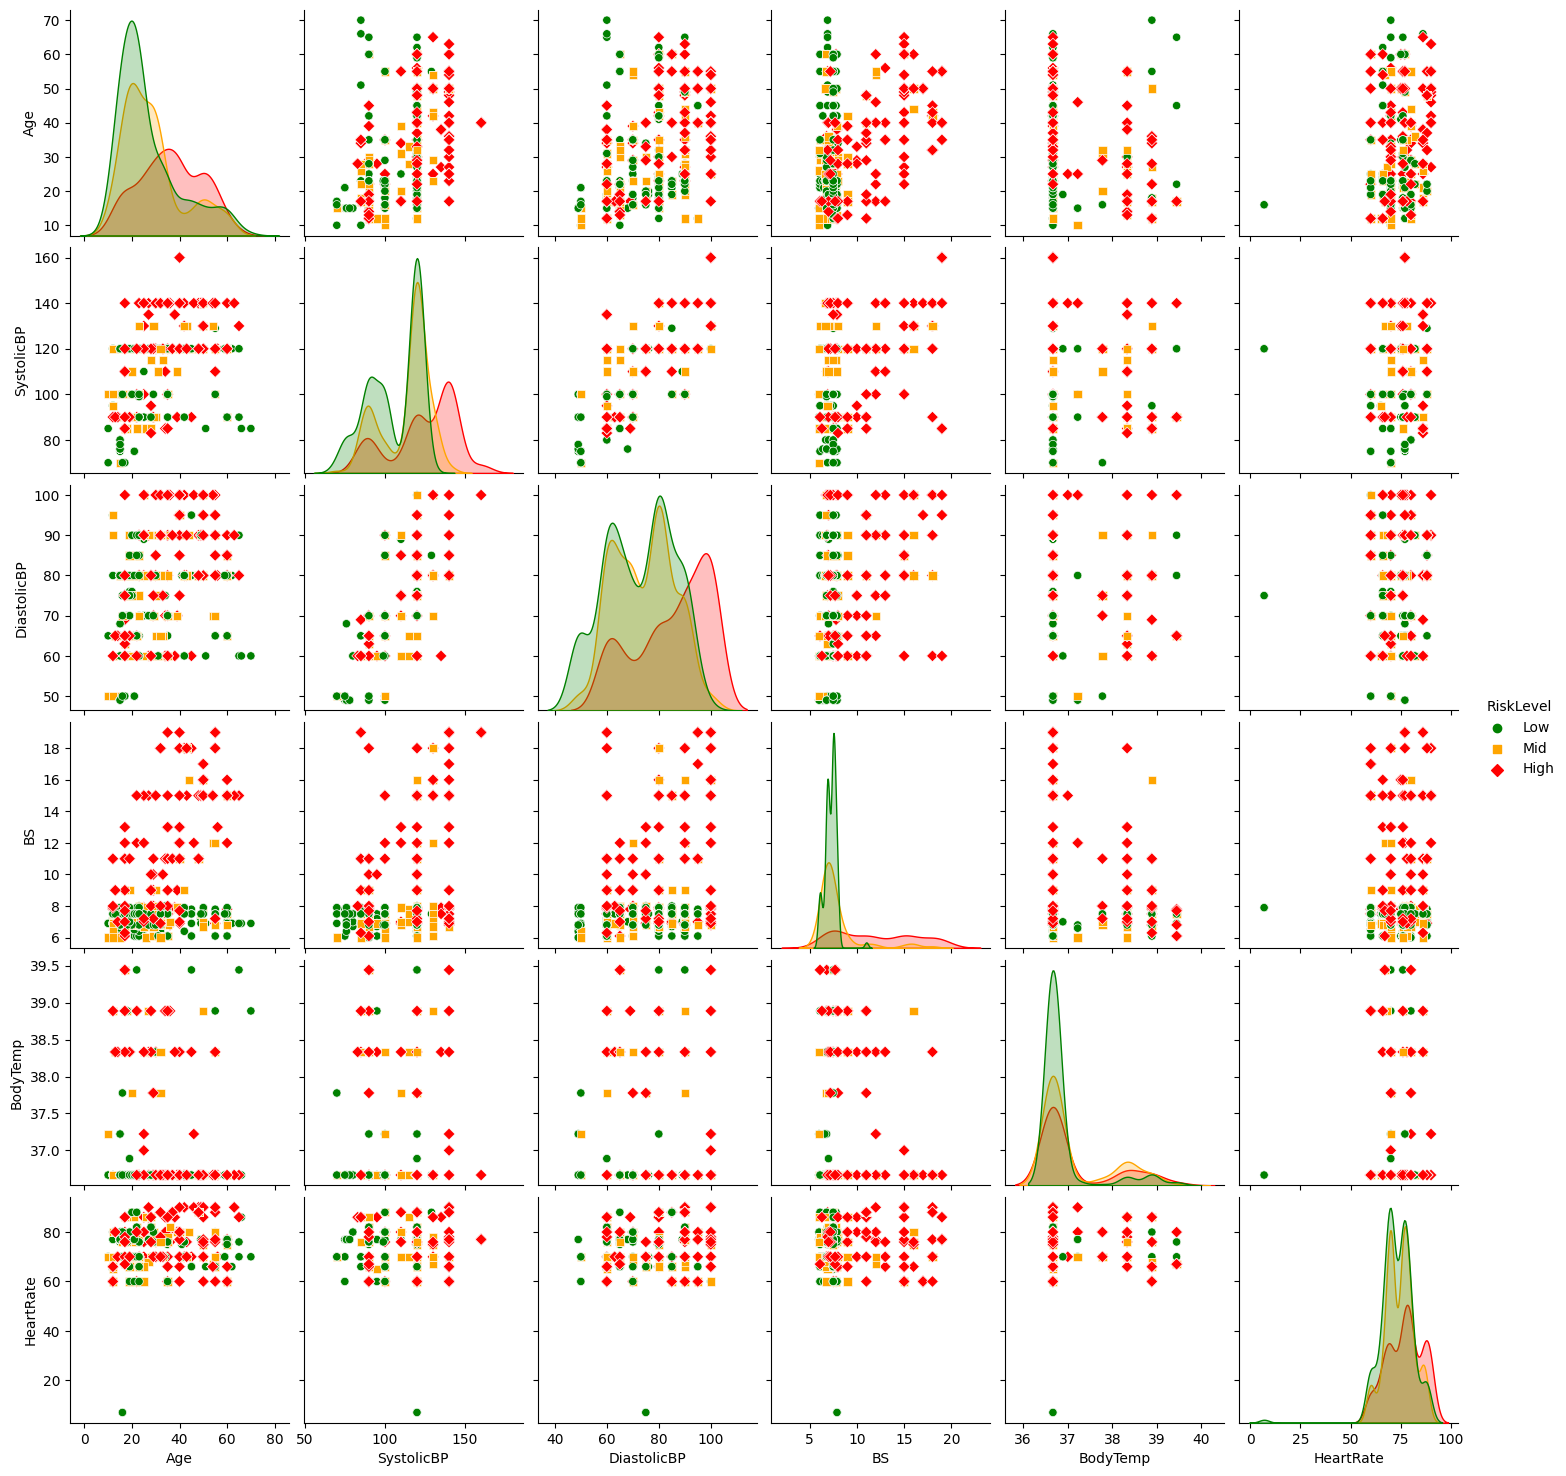

In [12]:
# Create a pairplot with RiskLevel
risk_colors = {0: "green", 1: "orange", 2: "red"}

plot = sns.pairplot(df, hue='RiskLevel', 
                    palette=risk_colors, 
                    markers=["o", "s", "D"])

legend_labels = {"0": "Low", "1": "Mid", "2": "High"}
for text, label in zip(plot._legend.texts, legend_labels.values()):
    text.set_text(label)

plt.show()

**Age:**
The EDA reveals that pregnant women below 24 years generally exhibit a lower health risk, while risks tend to rise from the age of 25. Notably, there is a surprising decrease in risk for women over 59 years, adding an intriguing dimension to the age-related health risk pattern.

**SystolicBP and DiastolicBP:**
A detailed examination of the correlation heatmap highlights a strong correlation between SystolicBP and DiastolicBP. Elevated values of both indicators correspond to higher health risks. Interestingly, low SystolicBP and DiastolicBP at a young age do not necessarily ensure low health risk, but a potential protective effect seems to emerge in older age.

**BS (Blood Glucose):**
Observations indicate that pregnant women with blood glucose levels of 8 or higher tend to face higher health risks, regardless of other variables in the dataset.

**BodyTemp:**
Analysis of body temperature unveils that most pregnant women maintain a body temperature around 36.7°C, within the normal range. Notably, higher body temperatures (>= 37.8°C) correlate with elevated health risks. Younger women with normal body temperatures predominantly exhibit low health risks, while the impact of high body temperatures on health risks appears less pronounced in older women. The combination of normal body temperature with low SystolicBP and DiastolicBP is associated with a lower health risk.

**HeartRate:**
An anomalous outlier is identified in heart rate, warranting further investigation. The analysis suggests an upward trend in health risks with increasing heart rates. However, compared to other variables, heart rate appears to exert a comparatively modest effect on pregnant women's health risks. 

# Dealing with Multicollinearity: SystolicBP and DiastolicBP

In [13]:
# Variance Inflation Factor (VIF) calculation
X = df[["SystolicBP", "DiastolicBP"]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Variable,VIF
0,SystolicBP,79.96833
1,DiastolicBP,79.96833


The significantly elevated Variance Inflation Factor (VIF) values for both SystolicBP and DiastolicBP, approximately 80, indicate an strong correlation between these two variables. This heightened level of multicollinearity implies potential challenges for the model in discerning the individual impacts of these blood pressure measures, leading to difficulties in accurately estimating coefficients.

Considering that diastolic dysfunction, characterized by impaired relaxation of the left ventricle, precedes systolic dysfunction in cardiac disease development, it emerges as a more informative and potentially predictive indicator for pregnancy complications. Studies have substantiated the link between diastolic dysfunction and the onset and severity of pre-eclampsia, underscoring its significance as a valuable predictor of pregnancy-related risks (George et al., 2015; Zhu et al., 2021). Therefore, prioritizing DiastolicBP in the model allows for a more focused and clinically relevant evaluation of cardiovascular health during pregnancy.

In [14]:
# Drop SystolicBP for model training
df = df.drop(["SystolicBP"], axis=1)

# Dealing with Outlier: HeartRate

In [15]:
# Identify the outlier in HeartRate
df.HeartRate.sort_values().head()

908     7
499     7
702    60
783    60
784    60
Name: HeartRate, dtype: int64

Outliers with a heart rate reading of 7 bpm have been identified, which significantly deviates from the typical range for normal pregnancies (Loerup et al., 2019). This anomalous data point is likely indicative of a data entry error or measurement anomaly. To ensure the integrity of the dataset and prevent undue influence on model training, the outlier will be removed.

In [16]:
# Remove the outlier in HeartRate
df = df.drop(df.index[df.HeartRate == 7])

# Model Building

In [17]:
# Feature scaling
columns = ["Age", "DiastolicBP", "BS", "BodyTemp", "HeartRate"]
scale_X = StandardScaler()
X = pd.DataFrame(scale_X.fit_transform(df.drop(["RiskLevel"],axis = 1),), columns = columns)
y = df["RiskLevel"]

In [18]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((809, 5), (203, 5), (809,), (203,))

In [19]:
X.head()

,Age,DiastolicBP,BS,BodyTemp,HeartRate
0,-0.363796,0.254566,1.903633,-0.485808,1.538308
1,0.378765,0.974379,1.296644,-0.485808,-0.589878
2,-0.066772,-0.465247,-0.220828,0.972192,0.740239
3,0.007484,0.614473,-0.524323,-0.485808,-0.589878
4,0.378765,-1.185059,-0.797468,-0.485808,0.208192


## Logistic Regression

In [20]:
# Baseline model of Logistic Regression
logistic_regression = linear_model.LogisticRegression()
logistic_regression_mod = logistic_regression.fit(X_train, y_train)
print(f"Baseline Logistic Regression: {round(logistic_regression_mod.score(X_test, y_test), 3)}")
pred_logistic_regression = logistic_regression_mod.predict(X_test)

Baseline Logistic Regression: 0.64


In [21]:
# Cross validate Logistic Regression model
scores_Logistic = cross_val_score(logistic_regression, X_train, y_train, cv=3, scoring="accuracy")
print(f"Scores(Cross validate) for Logistic Regression model:\n{scores_Logistic}")
print(f"CrossValMeans: {round(scores_Logistic.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_Logistic.std(), 3)}")

Scores(Cross validate) for Logistic Regression model:
[0.6037037  0.5962963  0.57992565]
CrossValMeans: 0.593
CrossValStandard Deviation: 0.01


In [22]:
params_LR = {"tol": [0.0001,0.0002,0.0003],
            "C": [0.01, 0.1, 1, 10, 100],
            "intercept_scaling": [1, 2, 3, 4],
            "solver": ["liblinear", "lbfgs", "newton-cg"],
            "max_iter": [100, 200, 300],
              }

In [23]:
GridSearchCV_LR = GridSearchCV(estimator=linear_model.LogisticRegression(), 
                                param_grid=params_LR, 
                                cv=3,
                                scoring="accuracy", 
                                return_train_score=True,
                                )

In [24]:
# Fit model with train data
GridSearchCV_LR.fit(X_train, y_train);

In [25]:
print(f"Best estimator for LR model:\n{GridSearchCV_LR.best_estimator_}")
print(f"Best parameter values for LR model:\n{GridSearchCV_LR.best_params_}")
print(f"Best score for LR model: {round(GridSearchCV_LR.best_score_, 3)}")

Best estimator for LR model:
LogisticRegression(C=0.01, solver='liblinear')
Best parameter values for LR model:
{'C': 0.01, 'intercept_scaling': 1, 'max_iter': 100, 'solver': 'liblinear', 'tol': 0.0001}
Best score for LR model: 0.602


In [26]:
# Test with new parameter
logistic_regression = linear_model.LogisticRegression(C=0.01, intercept_scaling=1, max_iter=100, solver="liblinear", tol=0.0001, random_state=42)
logistic_regression_mod = logistic_regression.fit(X_train, y_train)
pred_logistic_regression = logistic_regression_mod.predict(X_test)

mse_logistic_regression = mean_squared_error(y_test, pred_logistic_regression)
rmse_logistic_regression = np.sqrt(mean_squared_error(y_test, pred_logistic_regression))
score_logistic_regression_train = logistic_regression_mod.score(X_train, y_train)
score_logistic_regression_test = logistic_regression_mod.score(X_test, y_test)

In [27]:
print(f"Mean Square Error for Logistic Regression = {round(mse_logistic_regression, 3)}")
print(f"Root Mean Square Error for Logistic Regression = {round(rmse_logistic_regression, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_logistic_regression_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_logistic_regression_test, 3)}")

Mean Square Error for Logistic Regression = 0.512
Root Mean Square Error for Logistic Regression = 0.716
R^2(coefficient of determination) on training set = 0.609
R^2(coefficient of determination) on testing set = 0.635


In [28]:
print("Classification Report")
print(classification_report(y_test, pred_logistic_regression))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_logistic_regression))

Classification Report
              precision    recall  f1-score   support

           0       0.59      0.88      0.70        81
           1       0.56      0.21      0.30        67
           2       0.77      0.80      0.79        55

    accuracy                           0.64       203
   macro avg       0.64      0.63      0.60       203
weighted avg       0.63      0.64      0.59       203

Confusion Matrix:
[[71  6  4]
 [44 14  9]
 [ 6  5 44]]


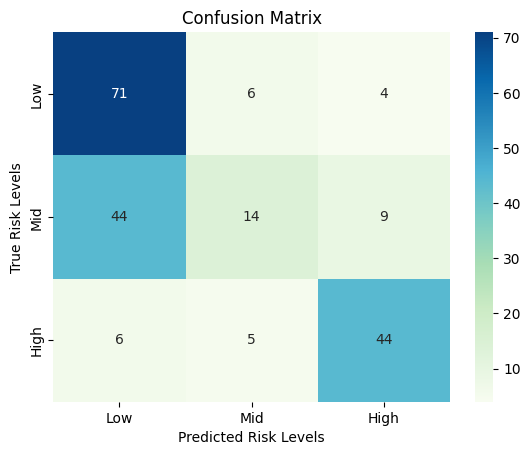

In [29]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_logistic_regression), annot=True, ax=ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels");  
ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

## K-Nearest Neighbors

In [30]:
# Baseline model of K-Nearest Neighbors
knn = KNeighborsClassifier()
knn_mod = knn.fit(X_train, y_train)
print(f"Baseline K-Nearest Neighbors: {round(knn_mod.score(X_test, y_test), 3)}")
pred_knn = knn_mod.predict(X_test)

Baseline K-Nearest Neighbors: 0.665


In [31]:
# Cross validate K-Nearest Neighbors model
scores_knn = cross_val_score(knn, X_train, y_train, cv=3, scoring="accuracy")
print(f"Scores(Cross validate) for K-Nearest Neighbors model:\n{scores_knn}")
print(f"CrossValMeans: {round(scores_knn.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_knn.std(), 3)}")

Scores(Cross validate) for K-Nearest Neighbors model:
[0.61481481 0.68148148 0.62453532]
CrossValMeans: 0.64
CrossValStandard Deviation: 0.029


In [32]:
params_knn = {"leaf_size": list(range(1,30)),
              "n_neighbors": list(range(1,21)),
              "p": [1,2],
              "weights": ["uniform", "distance"],
             }

In [33]:
GridSearchCV_knn = GridSearchCV(estimator=KNeighborsClassifier(), 
                                param_grid=params_knn,
                                cv=3,
                                scoring="accuracy",
                                return_train_score=True
                                )

In [34]:
# Fit model with train data
GridSearchCV_knn.fit(X_train, y_train);

In [35]:
print(f"Best estimator for KNN model:\n{GridSearchCV_knn.best_estimator_}")
print(f"Best parameter values:\n{GridSearchCV_knn.best_params_}")
print(f"Best score for GNB model: {round(GridSearchCV_knn.best_score_, 3)}")

Best estimator for KNN model:
KNeighborsClassifier(leaf_size=1, n_neighbors=10, weights='distance')
Best parameter values:
{'leaf_size': 1, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best score for GNB model: 0.795


In [36]:
# Test with new parameter
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=2, weights="distance")
knn_mod = knn.fit(X_train, y_train)
pred_knn = knn_mod.predict(X_test)

mse_knn = mean_squared_error(y_test, pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, pred_knn))
score_knn_train = knn_mod.score(X_train, y_train)
score_knn_test = knn_mod.score(X_test, y_test)

In [37]:
print(f"Mean Square Error for K_Nearest Neighbor  = {round(mse_knn, 3)}")
print(f"Root Mean Square Error for K_Nearest Neighbor = {round(rmse_knn, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_knn_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_knn_test, 3)}")

Mean Square Error for K_Nearest Neighbor  = 0.251
Root Mean Square Error for K_Nearest Neighbor = 0.501
R^2(coefficient of determination) on training set = 0.934
R^2(coefficient of determination) on testing set = 0.837


In [38]:
print("Classification Report")
print(classification_report(y_test, pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_knn))

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        81
           1       0.77      0.85      0.81        67
           2       0.88      0.93      0.90        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.84       203
weighted avg       0.84      0.84      0.84       203

Confusion Matrix:
[[62 17  2]
 [ 5 57  5]
 [ 4  0 51]]


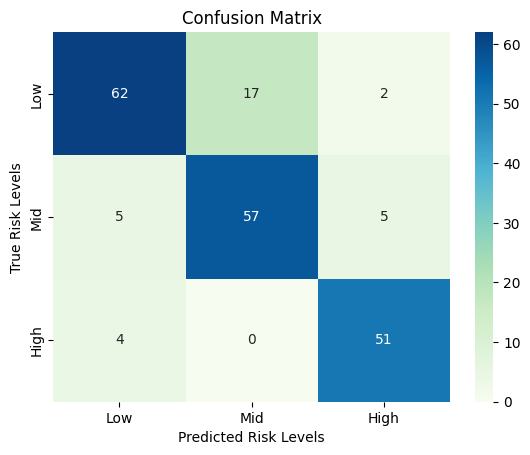

In [39]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_knn), annot=True, ax = ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels"); 
ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

## Random Forest

In [40]:
# Baseline model of Random Forest Classifier
random_forest = RandomForestClassifier()
random_forest_mod = random_forest.fit(X_train, y_train)
print(f"Baseline Random Forest: {round(random_forest_mod.score(X_test, y_test), 3)}")
pred_random_forest = random_forest_mod.predict(X_test)

Baseline Random Forest: 0.842


In [41]:
# Cross validate Random Forest Classifier model
scores_RF = cross_val_score(random_forest, X_train, y_train, cv=3, scoring = "accuracy")
print(f"Scores(Cross validate) for Random forest model:\n{scores_RF}")
print(f"CrossValMeans: {round(scores_RF.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_RF.std(), 3)}")

Scores(Cross validate) for Random forest model:
[0.80740741 0.81851852 0.82899628]
CrossValMeans: 0.818
CrossValStandard Deviation: 0.009


In [42]:
params_RF = {"min_samples_split": [2, 6, 20],
              "min_samples_leaf": [1, 2, 4],
              "n_estimators" :[50,100,200,300,400],
              "max_depth": [None, 10, 20, 30],
              "criterion": ["gini", "entropy"]             
              }

In [43]:
GridSearchCV_RF = GridSearchCV(estimator=RandomForestClassifier(), 
                                param_grid=params_RF,
                                cv=3,
                                scoring="accuracy",
                                return_train_score=True
                                )

In [44]:
# Fit model with train data
GridSearchCV_RF.fit(X_train, y_train);

In [45]:
print(f"Best estimator for RF model:\n{GridSearchCV_RF.best_estimator_}")
print(f"Best parameter values for RF model:\n{GridSearchCV_RF.best_params_}")
print(f"Best score for RF model: {round(GridSearchCV_RF.best_score_, 3)}")

Best estimator for RF model:
RandomForestClassifier(max_depth=10, n_estimators=200)
Best parameter values for RF model:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score for RF model: 0.818


In [46]:
# Test with new parameter
random_forest = RandomForestClassifier(criterion="entropy", max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)
random_forest_mod = random_forest.fit(X_train, y_train)
pred_random_forest = random_forest_mod.predict(X_test)

mse_random_forest = mean_squared_error(y_test, pred_random_forest)
rmse_random_forest = np.sqrt(mean_squared_error(y_test, pred_random_forest))
score_random_forest_train = random_forest_mod.score(X_train, y_train)
score_random_forest_test = random_forest_mod.score(X_test, y_test)

In [47]:
print(f"Mean Square Error for Random Forest = {round(mse_random_forest, 3)}")
print(f"Root Mean Square Error for Random Forest = {round(rmse_random_forest, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_random_forest_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_random_forest_test, 3)}")

Mean Square Error for Random Forest = 0.236
Root Mean Square Error for Random Forest = 0.486
R^2(coefficient of determination) on training set = 0.934
R^2(coefficient of determination) on testing set = 0.837


In [48]:
print("Classification Report")
print(classification_report(y_test, pred_random_forest))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_random_forest))

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        81
           1       0.79      0.79      0.79        67
           2       0.87      0.96      0.91        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.84       203
weighted avg       0.84      0.84      0.84       203

Confusion Matrix:
[[64 14  3]
 [ 9 53  5]
 [ 2  0 53]]


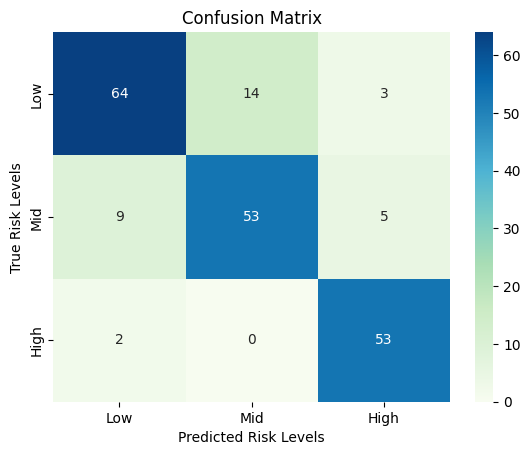

In [49]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_random_forest), annot=True, ax = ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels"); 
ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

## Gradient Boosting Classifier

In [50]:
# Baseline model of gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc_mod = gbc.fit(X_train, y_train)
print(f"Baseline gradient boosting classifier: {round(gbc_mod.score(X_test, y_test), 3)}")
pred_gbc = gbc_mod.predict(X_test)

Baseline gradient boosting classifier: 0.783


In [51]:
# Cross validate Gradient Boosting Classifier model
scores_GBC = cross_val_score(gbc, X_train, y_train, cv=3, scoring = "accuracy")
print(f"Scores(Cross validate) for Gradient Boosting Classifier model:\n{scores_GBC}")
print(f"CrossValMeans: {round(scores_GBC.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_GBC.std(), 3)}")

Scores(Cross validate) for Gradient Boosting Classifier model:
[0.74814815 0.78518519 0.80297398]
CrossValMeans: 0.779
CrossValStandard Deviation: 0.023


In [52]:
params_GBC = {"loss": ["deviance", "exponential"],
              "learning_rate": [0.01, 0.05, 0.075, 0.1], 
              "n_estimators": [100, 250, 500],
              "max_depth": [3, 5, 8, 10],
              "subsample": [0.8, 1],
              }

In [53]:
GridSearchCV_GBC = GridSearchCV(estimator=GradientBoostingClassifier(), 
                                param_grid=params_GBC,
                                cv=3,
                                scoring="accuracy", 
                                return_train_score=True
                                )

In [54]:
# Fit model with train data
GridSearchCV_GBC.fit(X_train, y_train);

In [55]:
print(f"Best estimator values for GBC model:\n{GridSearchCV_GBC.best_estimator_}")
print(f"Best parameter values for GBC model:\n{GridSearchCV_GBC.best_params_}")
print(f"Best score value foe GBC model: {round(GridSearchCV_GBC.best_score_, 3)}")

Best estimator values for GBC model:
GradientBoostingClassifier(learning_rate=0.05, loss='deviance', max_depth=5,
                           n_estimators=250, subsample=0.8)
Best parameter values for GBC model:
{'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.8}
Best score value foe GBC model: 0.821


In [56]:
# Test with new parameter
gbc = GradientBoostingClassifier(learning_rate=0.5, loss="deviance", max_depth=10, n_estimators=100, subsample=1,random_state=42)
gbc_mod = gbc.fit(X_train, y_train)
pred_gbc = gbc_mod.predict(X_test)

mse_gbc = mean_squared_error(y_test, pred_gbc)
rmse_gbc = np.sqrt(mean_squared_error(y_test, pred_gbc))
score_gbc_train = gbc_mod.score(X_train, y_train)
score_gbc_test = gbc_mod.score(X_test, y_test)

In [57]:
print(f"Mean Square Error for Gradient Boosting Classifier = {round(mse_gbc, 3)}")
print(f"Root Mean Square Error for Gradient Boosting Classifier = {round(rmse_gbc, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_gbc_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_gbc_test, 3)}")

Mean Square Error for Gradient Boosting Classifier = 0.232
Root Mean Square Error for Gradient Boosting Classifier = 0.481
R^2(coefficient of determination) on training set = 0.934
R^2(coefficient of determination) on testing set = 0.842


In [58]:
print("Classification Report")
print(classification_report(y_test, pred_gbc))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_gbc))

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.79      0.83        81
           1       0.79      0.81      0.80        67
           2       0.87      0.96      0.91        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.85       203
weighted avg       0.84      0.84      0.84       203

Confusion Matrix:
[[64 14  3]
 [ 8 54  5]
 [ 2  0 53]]


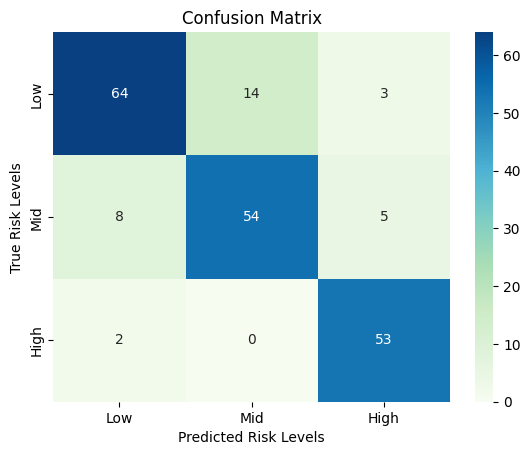

In [59]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_gbc), annot=True, ax = ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels"); 
ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

# Model Selection

In [60]:
# Create a DataFrame to store model evaluation results
results = pd.DataFrame({
    "Model": ["Logistic Regression", "K-Nearest Neighbors", "Random Forest", "Gradient Boosting Classifier"],
    "Train Score": [
        # Calculate mean cross-validated accuracy for training set
        cross_val_score(logistic_regression_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(knn_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(random_forest_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(gbc_mod, X_train, y_train, cv=3).mean(),
    ],
    "Test Score": [
        # Calculate accuracy on the test set
        logistic_regression_mod.score(X_test, y_test),
        knn_mod.score(X_test, y_test),
        random_forest_mod.score(X_test, y_test),
        gbc_mod.score(X_test, y_test),
    ]
})
# Additional Metrics (precision, recall, F1 score)
metrics = ["precision", "recall", "f1"]
for metric in metrics:
    results[f"{metric.capitalize()}"] = [
        precision_recall_fscore_support(y_test, model.predict(X_test), average="weighted")[metrics.index(metric)]
        for model in [logistic_regression_mod, knn_mod, random_forest_mod, gbc_mod]
    ]

result_df = results.sort_values(by="Test Score", ascending=False)
result_df = result_df.set_index("Test Score")
result_df

,Model,Train Score,Precision,Recall,F1
Test Score,,,,,
0.842365,Gradient Boosting Classifier,0.813365,0.842595,0.842365,0.841128
0.837438,K-Nearest Neighbors,0.794818,0.840899,0.837438,0.836922
0.837438,Random Forest,0.810891,0.836980,0.837438,0.836060
0.635468,Logistic Regression,0.601960,0.628104,0.635468,0.593824


In the evaluation of model performance, the Gradient Boosting Classifier emerges as the standout performer among the considered models. With a test accuracy of 84.23%, it surpasses both the K-Nearest Neighbors and Random Forest models, which exhibit commendable test accuracies of 83.74% each. Notably, the Gradient Boosting Classifier's test score outstrips its train score, indicating robust generalization and mitigating concerns of overfitting. Moreover, this model demonstrates superior precision, recall, and F1 score, reflecting a well-balanced performance across various evaluation metrics. The KNN model closely follows, excelling in precision and recall, while the Random Forest model performs well but shows a slight dip in precision. Conversely, the Logistic Regression model consistently lags in all metrics, highlighting its comparatively lower effectiveness. Consequently, the Gradient Boosting Classifier stands out as the preferred choice for this classification task, offering a compelling balance between precision, recall, and overall accuracy.

# Conclusion

In conclusion, this project has yielded valuable insights into the classification of health risk among pregnant women using machine learning models. Through a meticulous evaluation of various algorithms, the Gradient Boosting Classifier emerged as the most effective model, showcasing superior accuracy, precision, recall, and F1 score compared to alternatives like K-Nearest Neighbors and Random Forest. The achievement of an 84.23% test accuracy reflects the model's generalization to unseen data and its potential to contribute to prenatal health risk assessment. The successful deployment of the Gradient Boosting Classifier could lead to enhanced decision-making in clinical settings, allowing for more accurate identification of health risks during pregnancy. Moving forward, further refinements and optimizations can be explored to enhance the model's predictive capabilities. Continuous data collection and feature engineering could contribute to a more comprehensive understanding of health risk factors during pregnancy. 

# References